# Recommendations with IBM

## Table of Contents

- [Introduction](#Intro)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Rank-Based Recommendations](#Rank)
- [User-User-Based Collaborative Filtering](#User-User)
- [Content-Based Recommendations](#Content-Recs)
- [Matrix Factorization](#Matrix-Fact)
- [Sources](#Sources)

<a id='Intro'></a>
## Introduction
[IBM Watson Studio](https://www.ibm.com/cloud/watson-studio) is a software platform for data science. The platform contains articles that provide useful information such as tutorials for users, summaries of developments in the field of data science, and much more. In this project, I will be building out several different methods for making article recommendations to users of IBM Watson Studio, including rank-based, user-user-based collaborative filtering, content-based, and matrix factorization techniques. The data provided by IBM contains details about which articles users have interacted with, as well as the content of each article on the platform.

Special thanks to the [Udacity Data Scientist Nanodegree](https://www.udacity.com/course/data-scientist-nanodegree--nd025) for providing the Jupyter Notebook template and test code.

I will start by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

import re
import nltk
nltk.download(['punkt', 'stopwords', 'wordnet'])
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/evanchen13/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/evanchen13/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/evanchen13/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


<a id='Exploratory-Data-Analysis'></a>
## Exploratory Data Analysis

I will use the following section to provide some insight into the descriptive statistics of the data.

First I want to find out, what is the distribution of how many articles a user interacts with? I will provide visualizations and descriptive statistics to give a look at the number of times each user interacts with an article.

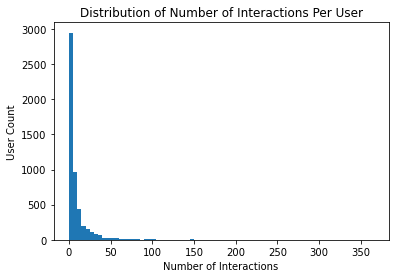

In [3]:
interactions_per_user = df.groupby('email').size()
bin_size = 5
bins = np.arange(0, interactions_per_user.max()+bin_size, bin_size)
plt.hist(interactions_per_user, bins=bins)
plt.title('Distribution of Number of Interactions Per User')
plt.xlabel('Number of Interactions')
plt.ylabel('User Count');

The visualization shows that the distribution of interactions per user is right-skewed, and because the x-scale stretches out to more than 350, it seems like there may be an outlier. Therefore, I will show the same distribution but on a logarithmic scale to better visualize the distribution.

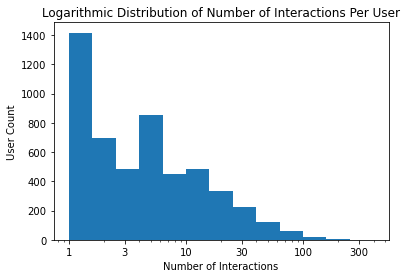

In [4]:
log_bin_size = 0.2
bins = 10**np.arange(
    np.log10(interactions_per_user.min()),
    np.log10(interactions_per_user.max())+log_bin_size,
    log_bin_size
)
xticks = [1, 3, 10, 30, 100, 300]
plt.hist(interactions_per_user, bins=bins)
plt.xscale('log')
plt.xticks(xticks, xticks)
plt.title('Logarithmic Distribution of Number of Interactions Per User')
plt.xlabel('Number of Interactions')
plt.ylabel('User Count');

Based on this histogram, it looks like almost all users have had 100 or fewer interactions, with the majority being less than 10. Most users have only interacted with one article, and the distribution gradually decreases from there, aside from a spike at about four interactions per user.

I will also show the descriptive statistics.

In [5]:
interactions_per_user.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
dtype: float64

In [6]:
# 50% of individuals interact with 3 articles or fewer
median_val = interactions_per_user.median()
# The maximum number of user-article interactions by any 1 user is 364
max_views_by_user = interactions_per_user.max()

Now I will explore and remove duplicate articles from the `df_content` dataframe.  

In [7]:
# Find and explore duplicate articles
df_content[df_content.duplicated(subset='article_id')]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [8]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset='article_id', inplace=True)

I will also find the following data points:

- The number of unique articles that have an interaction with a user.  
- The number of unique articles in the dataset (whether they have any interactions or not).
- The number of unique users in the dataset (excluding null values).
- The number of user-article interactions in the dataset.

In [9]:
# The number of unique articles that have at least one interaction
unique_articles = df['article_id'].nunique()
# The number of unique articles on the IBM platform
total_articles = df_content.shape[0]
# The number of unique users
unique_users = df['email'].nunique()
# The number of user-article interactions
user_article_interactions = df.shape[0]

I also want to see the most viewed `article_id`, as well as how often it was viewed.

In [10]:
# The most viewed article in the dataset 
most_viewed_article_id = str(df['article_id'].value_counts().index[0])
# The most viewed article in the dataset was viewed this many times
max_views = df['article_id'].value_counts().values[0]

Udacity talked to IBM leaders and deemed that the following `email_mapper` function is a reasonable way to map users to IDs. There are a small number of null values, and it was found that all of these null values likely belong to a single user (which is how they are stored using the function below).

In [11]:
def email_mapper():
    '''
    INPUT:
    None
    
    OUTPUT:
    email_encoded - (list) user ids representing user emails
    
    Description:
    Maps the user email to a user_id column and removes the email column
    '''
    
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


Now I will compare my results against Udacity's.

In [12]:
sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


<a id='Rank'></a>
## Rank-Based Recommendations

Rank-based systems provide recommendations based on the highest popularity, whether that is measured by ratings, frequency of use, or some other metric.

The data provided by IBM does not have ratings for whether a user liked an article or not. It only shows whether a user has interacted with an article. As a result, the popularity of an article can really only be based on how often an article was interacted with.

To provide the rank-based recommendations, the following function returns the **n** top articles ordered with most interactions as the top.

In [13]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (Pandas DataFrame) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top n article titles 
    
    Description:
    Returns the top article titles based on the number of interactions per article
    '''
    
    # group by article_id and title, then sort by the count to get the top_articles
    sorted_articles = df.groupby(['article_id', 'title'], as_index=False).count()
    sorted_articles = sorted_articles.sort_values('user_id', ascending=False)
    top_articles = list(sorted_articles.head(n)['title'].values)
    
    # Return the top article titles from df (not df_content)
    return top_articles

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (Pandas DataFrame) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top n article ids 
    
    Description:
    Returns the top article ids based on the number of interactions per article
    '''
    
    top_articles = list(df['article_id'].value_counts().index[:n])
 
    # Return the top article ids
    return top_articles

I will test out my functions by finding the top 10 article names and IDs.

In [14]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


I will also test my function against Udacity's solution.

In [15]:
# Test function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of the three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


<a id='User-User'></a>
## User-User-Based Collaborative Filtering</a>

Collaborative filtering systems use the interactions between users and products to provide recommendations. For the user-user-based collaborative filtering, I will create a matrix, with `user_id` as the rows and `article_id` as the columns, that shows whether a user has interacted with an article. I will take the dot product of this matrix with its transpose to find the similarity between users. Then, to make recommendations for a given user, I will find the most similar users and recommend the articles that those users have interacted with that the given user has not seen.

I will use the following function to reformat the `df` dataframe to be shaped with users as the rows and articles as the columns. The result should satisfy the following:

- Each `user_id` should only appear in each row once.
- Each `article_id` should only show up in one column.  
- If a user has interacted with an article, then I will place a 1 where the user-row meets for that article-column. It does not matter how many times a user has interacted with the article; all entries where a user has interacted with an article should be a 1.  
- If a user has not interacted with an item, then I will place a 0 where the user-row meets for that article-column. 

I will also use the tests provided by Udacity to make sure the basic structure of the matrix matches what is expected by the solution.

In [16]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - Pandas DataFrame with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Returns a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    
    # pivot the data
    user_item = df.groupby(['user_id', 'article_id'])['user_id'].nunique().unstack()
    # the resulting matrix shows NaN where users have not interacted with an article, so fill those with 0
    user_item.fillna(value=0, inplace=True)
    
    # return the user_item matrix 
    return user_item

user_item = create_user_item_matrix(df)

In [17]:
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


The following function will take a `user_id` and provide an ordered list of the most similar users to that user (from most similar to least similar), excluding the provided `user_id`. Because the interactions for each user are binary, it makes sense to compute similarity as the dot product of two users. 

In [18]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (Pandas DataFrame) matrix of users by articles: 
                1 when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered list of similar users
    '''
    
    # compute similarity of each user to the provided user
    user_item_matrix = np.array(user_item)
    idx = np.where(user_item.index == user_id)[0][0]
    similarity = np.dot(user_item_matrix[idx], user_item_matrix.T)

    # sort by similarity
    similarity_idxs = similarity.argsort()[::-1]

    # create list of just the ids
    most_similar_users = list(user_item.index[similarity_idxs])
   
    # remove the own user's id
    most_similar_users.remove(user_id)
       
    # return a list of the users in order from most to least similar
    return most_similar_users
        

I will test out the function below.

In [19]:
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


Now that I have a function that provides the most similar users to each user, I will utilize these users to find articles to recommend. Combined together, the functions below will return the articles to recommend to each user.

In [20]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (Pandas DataFrame) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    
    Description:
    Looks up article names based on the provided article ids
    '''
    
    # find each unique article_id and title combination from df, then look up the article_ids
    article_titles = df[['article_id', 'title']]
    article_titles.drop_duplicates(inplace=True)
    article_names = list(article_titles.query('article_id in @article_ids')['title'])
    
    # Return the article names associated with list of article ids
    return article_names


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (Pandas DataFrame) matrix of users by articles: 
                1 when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    
    # find the row for the given user_id
    user_item_row = user_item[user_item.index == user_id]
    # find the columns where the value is 1, meaning that the user has interacted with that article
    # drop the columns that do not have 1
    article_ids = list(user_item_row[user_item_row == 1].dropna(axis=1).columns)
    article_names = get_article_names(article_ids)
    
    # return the ids and names
    return article_ids, article_names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user has not seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the next user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    '''
    
    # find the articles that the given user_id has seen
    articles_seen_ids, articles_seen_names = get_user_articles(user_id)
    # find similar users to the given user_id
    similar_users = find_similar_users(user_id)
    
    full_recs = np.array([])
    
    for user in similar_users:
        # find the articles that the similar user has seen
        user_articles_ids, user_articles_names = get_user_articles(user)
        # take the articles that the similar user has seen that the given user_id has not
        articles_not_seen = np.setdiff1d(np.array(user_articles_ids), np.array(articles_seen_ids), assume_unique=True)
        # add the recs and make sure there are no duplicates
        full_recs = np.unique(np.concatenate((full_recs, articles_not_seen)))
        if len(full_recs) >= m:
            break
    
    # the full_recs may be more than m, so only take the first m recs
    recs = list(full_recs)[:m]
    
    # return your recommendations for this user_id 
    return recs   

I will check to see that the functions work and match Udacity's solution.

In [21]:
# Return 10 recommendations for user 1
get_article_names(user_user_recs(1, 10))

['got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'timeseries data analysis of iot events by using jupyter notebook',
 'graph-based machine learning',
 'using brunel in ipython/jupyter notebooks',
 'experience iot with coursera',
 'the 3 kinds of context: machine learning and the art of the frame',
 'deep forest: towards an alternative to deep neural networks',
 'this week in data science (april 18, 2017)',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty']

In [22]:
assert set(get_article_names([1024.0, 1176.0, 1305.0, 1314.0, 1422.0, 1427.0])) == \
       set(['using deep learning to reconstruct high-resolution audio',
            'build a python app on the streaming analytics service',
            'gosales transactions for naive bayes model',
            'healthcare python streaming application demo',
            'use r dataframes & ibm watson natural language understanding',
            'use xgboost, scikit-learn & ibm watson machine learning apis']),\
       "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names([1320.0, 232.0, 844.0])) == \
       set(['housing (2015): united states demographic measures',
            'self-service data preparation with ibm data refinery',
            'use the cloudant-spark connector in python notebook']),\
       "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set([1320.0, 232.0, 844.0])
assert set(get_user_articles(20)[1]) == \
       set(['housing (2015): united states demographic measures',
            'self-service data preparation with ibm data refinery',
            'use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set([1024.0, 1176.0, 1305.0, 1314.0, 1422.0, 1427.0])
assert set(get_user_articles(2)[1]) == \
       set(['using deep learning to reconstruct high-resolution audio',
            'build a python app on the streaming analytics service',
            'gosales transactions for naive bayes model',
            'healthcare python streaming application demo',
            'use r dataframes & ibm watson natural language understanding',
            'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


Now I will enhance the `user_user_recs` function. Instead of arbitrarily choosing when users are all the same closeness to a given user, I will choose the users that have the most total article interactions before choosing those with fewer article interactions. Additionally, instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, I will choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking is what would be obtained from the `get_top_articles` function from earlier.

In [23]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (Pandas DataFrame) df as defined at the top of the notebook 
    user_item - (Pandas DataFrame) matrix of users by articles: 
            1 when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (Pandas DataFrame) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user
                    
    Description:
    Sort the neighbors by the similarity and then by number of interactions where 
    highest of each is higher in the dataframe
    '''
    
    neighbors_dict = {}
    
    # compute similarity of each user to the provided user
    user_item_matrix = np.array(user_item)
    idx = np.where(user_item.index == user_id)[0][0]
    similarity = np.dot(user_item_matrix[idx], user_item_matrix.T)
    
    neighbor_id = user_item.index
    
    # create DataFrame using dictionary
    neighbors_dict['neighbor_id'] = list(neighbor_id)
    neighbors_dict['similarity'] = list(similarity)
    neighbors_df = pd.DataFrame(neighbors_dict)
    
    # find the number of interactions per user and merge with neighbors_df
    user_interactions = df['user_id'].value_counts().reset_index()
    user_interactions.rename(columns={'index': 'neighbor_id', 'user_id': 'num_interactions'}, inplace=True)
    neighbors_df = neighbors_df.merge(user_interactions, how='left', on='neighbor_id')
    # remove the given user_id
    neighbors_df = neighbors_df.query('neighbor_id != @user_id')
    # sort first by similarity, then by num_interactions
    neighbors_df.sort_values(['similarity', 'num_interactions'], ascending=False, inplace=True)
    
    # Return the dataframe specified in the doc_string
    return neighbors_df


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user has not seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.
    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
    '''
    
    # find the articles that the given user_id has seen
    articles_seen_ids, articles_seen_names = get_user_articles(user_id)
    
    full_recs = np.array([])
    
    neighbors_df = get_top_sorted_users(user_id)
    for neighbor_id in neighbors_df['neighbor_id']:
        # find the articles that the neighbor_id has seen
        neighbor_article_ids, neighbor_article_names = get_user_articles(neighbor_id)
        # take the articles that the neighbor_id has seen that the given user_id has not
        articles_not_seen = np.setdiff1d(
            np.array(neighbor_article_ids),
            np.array(articles_seen_ids),
            assume_unique=True
        )
        # add the recs and make sure there are no duplicates
        full_recs = np.unique(np.concatenate((full_recs, articles_not_seen)))
        if len(full_recs) >= m:
            break
            
    # find the number of interactions per article and only take the first m recs
    article_interactions = df['article_id'].value_counts().reset_index()
    recs = article_interactions.query('index in @full_recs')['index']
    recs = list(recs)[:m]
    rec_names = get_article_names(recs)
        
    return recs, rec_names

I will check that the functions work and test them against Udacity's solution.

In [24]:
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1330.0, 1427.0, 1364.0, 1170.0, 1162.0, 1304.0, 1351.0, 1160.0, 1354.0, 1368.0]

The top 10 recommendations for user 20 are the following article names:
['apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'putting a human face on machine learning', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning']


In [25]:
# Find the user that is most similar to user 1 
user1_most_sim = get_top_sorted_users(1).iloc[0]['neighbor_id']
# Find the 10th most similar user to user 131
user131_10th_sim = get_top_sorted_users(131).iloc[9]['neighbor_id']

In [26]:
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


For new users, because there is no data on what articles they have interacted with, I would not be able to use the user-user-based collaborative filtering. This is known as the cold start problem. I would only be able to use the rank-based recommendations with `get_top_articles` or `get_top_article_ids` for now. However, a better method might be to provide the top articles and have the new user select articles that look interesting, without actually interacting with them. From there, I could then use the `user_user_recs_part2` function to find similar users and provide recommendations.

Using the existing functions, I will provide the top 10 recommended articles for a new user. I will also test the result against Udacity's solution.

In [27]:
# Provide a list of the top 10 article ids you would give to a new user
new_user_recs = get_top_article_ids(10)

In [28]:
assert set(new_user_recs) == set([1314.0,1429.0,1293.0,1427.0,1162.0,1364.0,1304.0,1170.0,1431.0,1330.0]),\
                             "Oops!  It makes sense that in this case we would want to recommend "\
                             "the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


<a id='Content-Recs'></a>
## Content-Based Recommendations

Content-based systems provide recommendations based on information about users or products. I can implement this by finding the similarity between articles based on their content, similar to what was done with users previously. In the following functions, I will use the `doc_description` column from `df_content` and use TFIDF to create a matrix with articles as the rows and tokens as the columns. Then I will take the dot product of this matrix with its transpose to get the similarity between articles and recommend those with the highest similarity.

First I will create a custom function to tokenize the `doc_description`.

In [29]:
def tokenize(text):
    '''
    INPUT:
    text - (str) doc_description text
    
    OUTPUT:
    tokens - (list) the doc_description text as individual tokens
    
    Description:
    Takes the doc_description text, removes punctuation and stop words, and lemmatizes tokens
    '''
    
    # remove punctuation and replace with space
    text = re.sub(r'[^\w]', ' ', text)
    # normalize text
    text = text.lower().strip()
    # split text into tokens
    tokens = word_tokenize(text)
    # remove stop words
    tokens = [token for token in tokens if token not in stopwords.words('english')]
    # lemmatize tokens
    tokens = [WordNetLemmatizer().lemmatize(token, pos='n') for token in tokens]
    tokens = [WordNetLemmatizer().lemmatize(token, pos='v') for token in tokens]
    
    return tokens

I will use this custom function to pass into scikit-learn's `TfidfVectorizer()`, and then use that to create a matrix with articles as rows and tokens as columns.

In [30]:
def create_token_matrix(df_content):
    '''
    INPUT:
    df_content - (Pandas DataFrame) dataframe with doc_description as a column
    
    OUTPUT:
    token_matrix - (array) array with articles as rows and tokens as columns
    
    Description:
    Uses TfidfVectorizer from scikit-learn to create an array with articles as rows and tokens as columns
    '''
    
    vectorizer = TfidfVectorizer(tokenizer=tokenize)
    doc_description = df_content['doc_description'].fillna(value='').values
    token_matrix = vectorizer.fit_transform(doc_description)
    # result is a sparse matrix, so convert to a dense ndarray representation
    token_matrix = token_matrix.toarray()
    
    return token_matrix

token_matrix = create_token_matrix(df_content)

Then I will find similar articles by taking the dot product of the matrix with its transpose.

In [31]:
def make_content_recs(article_id, token_matrix=token_matrix, m=10):
    '''
    INPUT:
    article_id - (int) article_id used to find similar articles
    token_matrix - (array) array with articles as rows and tokens as columns
    m - (int) number of recommendations
    
    OUTPUT:
    recs - (list) recommended article ids
    rec_names (list) recommended article titles
    
    Descripton:
    Uses the token matrix to find similar articles to the given article_id based on content
    '''
    
    # compute similarity of each article to the provided article
    idx = np.where(df_content['article_id'] == article_id)[0][0]
    similarity = np.dot(token_matrix[idx], token_matrix.T)
    
    # sort by similarity
    similarity_idxs = similarity.argsort()[::-1]
    
    # create list of the ids and remove the given article_id
    recs = list(df_content['article_id'].iloc[similarity_idxs])
    recs.remove(article_id)
    recs = recs[:m]
    # return article names based on the ids
    rec_names = list(df_content.query('article_id in @recs')['doc_full_name'])
    
    return recs, rec_names

I will make sure that the function works properly below.

In [32]:
# make a recommendations for a user who only has interacted with article id 786.0
make_content_recs(786)

([408, 789, 466, 830, 328, 1002, 879, 797, 290, 135],
 ['Simple CouchDB and Cloudant Backup',
  'Elasticsearch Tools & Compose',
  'Now available on IBM Bluemix',
  "Let's Encrypt TLS Certificates",
  "Compose's Data Browser comes to Elasticsearch",
  "Java and Let's Encrypt certificates",
  'Reintroducing the Simple Search Service',
  'Getting Started with Elasticsearch using Compose',
  'Do you know why Compose proxies database connections?',
  "New features for Compose's ScyllaDB"])

One improvement that could be made to this content-based recommendation system is to take into account the `doc_full_name` and `doc_body` columns in `df_content` in addition to `doc_description`, which is what I used. This would provide more data to determine the content of an article.

Additionally, another improvement could be to incorporate some knowledge-based methods, which use knowledge about users' preferences to make recommendations. To implement this, I could allow the user to search for a keyword, and the recommendation system would then provide the top articles with that keyword, based on number of interactions or the frequency of that keyword.

<a id='Matrix-Fact'></a>
## Matrix Factorization

Matrix factorization uses latent features to make recommendations. Latent features are features implied by data, but not explicitly observed. By looking at the relationship between users and latent features, latent features and products, and the importance of each latent feature, matrix factorization allows us to predict how a user and product will interact. In this part of the project, I will use matrix factorization to make article recommendations to users on the IBM Watson Studio platform.

In [33]:
# Load the user_item_matrix from Udacity here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [34]:
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In this situation, I will use Singular Value Decomposition (SVD) on the `user_item_matrix`.

In [35]:
u, s, vt = np.linalg.svd(user_item_matrix)

The dot product of `u`, `s`, and `vt` results in predicted values for user-item interactions. The number of latent features are in the number of columns of `u`, the number of rows and columns of `s`, and the number of rows of `vt`. In order to see the number of latent features to use, I will plot the accuracy as the number of latent features increases, leveraging some code provided by Udacity.

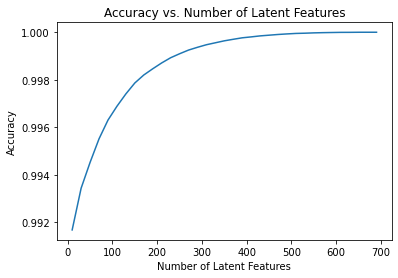

In [36]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/(user_item_matrix.shape[0]*user_item_matrix.shape[1]));
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

As the number of latent features increases, there is higher accuracy on making predictions for the 1 and 0 values in the user-item matrix.

From the above, I cannot really be sure how many features to use, because simply having a better way to predict the values of the matrix does not give an indication of if I am able to make good recommendations. Instead, I will split the dataset into a training and test set.  

Using the training and test sets, I want to understand:

- How many users can I make predictions for in the test set?  
- How many users can I not make predictions for because of the cold start problem?
- How many articles can I make predictions for in the test set?  
- How many articles can I not make predictions for because of the cold start problem?

In [37]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    Description:
    Returns a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise, for both training and test sets
    Also returns all user and article ids from the test set
    '''
    
    # pivot the training and test data
    user_item_train = df_train.groupby(['user_id', 'article_id'])['user_id'].nunique().unstack()
    user_item_train.fillna(value=0, inplace=True)
    user_item_test = df_test.groupby(['user_id', 'article_id'])['user_id'].nunique().unstack()
    user_item_test.fillna(value=0, inplace=True)
    
    test_idx = df_test['user_id']
    test_arts = df_test['article_id']
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [38]:
# find the number of users in the test set that are also in the training set
len(np.intersect1d(np.array(test_idx), np.array(df_train['user_id'])))

20

In [39]:
# find the number of users in the test set that are not in the training set
len(np.setdiff1d(np.array(test_idx), np.array(df_train['user_id'])))

662

In [40]:
# find the number of articles in the test set that are also in the training set
len(np.intersect1d(np.array(test_arts), np.array(df_train['article_id'])))

574

In [41]:
# find the number of articles in the test set that are not in the training set
len(np.setdiff1d(np.array(test_arts), np.array(df_train['article_id'])))

0

I will test these results against Udacity's solution.

In [42]:
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


Now I will perform SVD using `user_item_train`, and then compare the accuracy against `user_item_test` using the `user_id` that are common to both. Then, similar to before, I will plot the accuracy as the number of latent features increases.

In [43]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

10 Latent Features - Predicted 0s: 11430.0, Predicted 1s: 50.0, Percentage of 1s: 0.4%
30 Latent Features - Predicted 0s: 11391.0, Predicted 1s: 89.0, Percentage of 1s: 0.8%
50 Latent Features - Predicted 0s: 11373.0, Predicted 1s: 107.0, Percentage of 1s: 0.9%
70 Latent Features - Predicted 0s: 11351.0, Predicted 1s: 129.0, Percentage of 1s: 1.1%
90 Latent Features - Predicted 0s: 11332.0, Predicted 1s: 148.0, Percentage of 1s: 1.3%
110 Latent Features - Predicted 0s: 11311.0, Predicted 1s: 169.0, Percentage of 1s: 1.5%
130 Latent Features - Predicted 0s: 11298.0, Predicted 1s: 182.0, Percentage of 1s: 1.6%
150 Latent Features - Predicted 0s: 11287.0, Predicted 1s: 193.0, Percentage of 1s: 1.7%
170 Latent Features - Predicted 0s: 11277.0, Predicted 1s: 203.0, Percentage of 1s: 1.8%
190 Latent Features - Predicted 0s: 11269.0, Predicted 1s: 211.0, Percentage of 1s: 1.8%
210 Latent Features - Predicted 0s: 11261.0, Predicted 1s: 219.0, Percentage of 1s: 1.9%
230 Latent Features - Predic

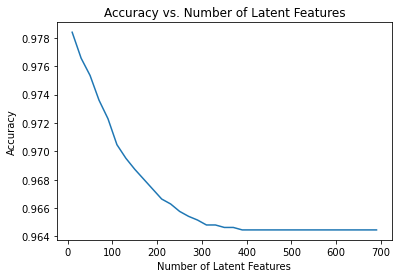

In [44]:
# find the user_id that are common to both user_item_train and user_item_test
# only keep those rows in user_item_test, to be used later to calculate accuracy
predictable_users = np.intersect1d(np.array(test_idx), np.array(df_train['user_id']))
user_item_test_new = user_item_test.loc[predictable_users]

# find the indices of rows and columns in user_item_train that are common to user_item_test_new
predictable_users_idxs = np.where(user_item_train.index.isin(predictable_users))[0]
test_arts_idxs = np.where(user_item_train.columns.isin(test_arts))[0]

total_predictions = user_item_test_new.shape[0]*user_item_test_new.shape[1]

num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # only keep the rows and columns that are common to user_item_test_new
    user_item_est_new = user_item_est[predictable_users_idxs, :]
    user_item_est_new = user_item_est_new[:, test_arts_idxs]
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_test_new, user_item_est_new)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    predicted_1 = np.sum(user_item_est_new)
    predicted_0 = total_predictions-predicted_1
    predicted_percent_1 = round(predicted_1/total_predictions*100, 1)
    print('{} Latent Features - Predicted 0s: {}, Predicted 1s: {}, Percentage of 1s: {}%'.format(
        k,
        predicted_0,
        predicted_1,
        predicted_percent_1
    ))
    
actual_1 = np.sum(np.sum(user_item_test_new))
actual_0 = total_predictions-actual_1
actual_percent_1 = round(actual_1/total_predictions*100, 1)
print('\nTest Set - 0s: {}, 1s: {}, Percentage of 1s: {}%'.format(actual_0, actual_1, actual_percent_1))
    
plt.plot(num_latent_feats, 1-np.array(sum_errs)/(total_predictions));
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

As the number of latent features increases, the accuracy actually decreases. This is due to overfitting -- as the number of latent features increases, using SVD overfits more to the training data and therefore becomes less accurate in predicting the test data. This did not occur previously because I did not split the data into training and test sets, and the resulting matrices from SVD were used to predict on the exact same data that they were derived from.

In this case, although it may seem like fewer latent features is better, the high accuracy is actually misleading as well, due to class imbalance. As shown by the predicted 0s and 1s above, fewer 1s are predicted when there are fewer latent features. And because only 1.9% of the values in the test set are 1s, SVD actually performs more accurately when it assumes that almost all of the values are 0s. However, if the recommendation system predicts that there will be no user-article interactions, then it would not be useful. Therefore, accuracy is the not the best metric to evaluate the recommendation system.

Overall, I could determine if any of the above recommendation systems are an improvement to how users currently find articles by performing an A/B test. One possible evaluation metric is the number of interactions per user over a given period of time; however, a higher number of interactions does not necessarily mean the recommendation system is working well. Perhaps users are having more interactions because they have to go through several articles to find ones that they like. Therefore, I would choose an evaluation metric that measures user engagement based on the amount of time spent per article. The null hypothesis would be that the average time per article for users of the new recommendation system is equal to or worse than the average time per article in the control situation, and the alternative hypothesis would be that the group with the new recommendation system has a higher average time per article.

<a id='Sources'></a>
## Sources

- [IBM Watson Studio](https://www.ibm.com/cloud/watson-studio)
- [Udacity Data Scientist Nanodegree](https://www.udacity.com/course/data-scientist-nanodegree--nd025)
- [Hide warnings](https://stackoverflow.com/questions/9031783/hide-all-warnings-in-ipython)
- [Convert sparse matrix to dense ndarray representation](https://stackoverflow.com/questions/26576524/how-do-i-transform-a-scipy-sparse-matrix-to-a-numpy-matrix)
- [Passing list-likes to .loc or [] with any missing labels is no longer supported](https://stackoverflow.com/questions/61291741/passing-list-likes-to-loc-or-with-any-missing-labels-is-no-longer-supported)